In [3]:
import numpy as np
from imageio import imread
from sklearn.model_selection import train_test_split
from IPython.display import display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import pandas as pd
from numpy.random import normal, uniform
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
import seaborn as sns
from sklearn.preprocessing import StandardScaler

def create_X(x, y, n ):
    L = ['1']
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)
            if (i == 0 and k == 0) :
                L.append('1')
            elif(i-k == 0):
                L.append('Y^' + str(k))
            elif (k == 0):
                L.append('X^' + str(i-k))
            elif (i==2 and k == 1):
                L.append('XY')
            elif(i-k == 1):
                L.append('X'+'Y^' + str(k))
            elif (k == 1):
                L.append('X^' + str(i-k)+'Y')
            else :
                L.append('X^' + str(i-k)+'Y^'+ str(k))
    return X, L


def accuracy_score_numpy(Y_test, Y_pred):
    return np.sum(Y_test == Y_pred) / len(Y_test)

In [4]:
#======================  DATA  

from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [5]:
#======================  Setup Data

df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [6]:
X = data.data
y = data.target
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [30]:
#--------- NN -----------#

np.random.seed(1) 


#Fonction d'activation sigmoide
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#Derive de notre fonction d'activation
def sigmoidPrime(x):
    return sigmoid(x) * (1 - sigmoid(x))


def activation_function(x, name):
    if (name == 'sigmoid'):
        return sigmoid(x)
    elif (name == 'relu'):
        return relu(x)
    
    
def activationPrime(x, name):
    if (name == 'sigmoid'):
        return sigmoidPrime(x)
    elif (name == 'relu'):
        return reluPrime(x)


#===================================
#           Training
#===================================

def NeuralNetwork(batch_size, nb_input_neurons,nb_hidden_neurons, nb_output_neurons, nb_features, 
                  nb_categories, nb_epochs, eta, lmbd, inputs, outputs, inputs_test, activation):
    
    iterations = nb_input_neurons // batch_size
    #Initialization of weights
    hidden_weights_1 = np.random.randn(nb_features, nb_hidden_neurons)
    hidden_bias_1 = np.zeros(nb_hidden_neurons) + 0.01
    hidden_weights_2 = np.random.randn(nb_hidden_neurons, nb_hidden_neurons)
    hidden_bias_2 = np.zeros(nb_hidden_neurons) + 0.01

    output_weights = np.random.randn(nb_hidden_neurons, nb_categories)
    output_bias = np.zeros(nb_categories) + 0.01

    for i in range(1, nb_epochs+1):

        np.random.shuffle(inputs)
        np.random.shuffle(outputs)

        for j in range(iterations):

            # minibatch training data
            random_index = np.random.randint(iterations)
            X_data = inputs[random_index:(random_index+1)]
            Y_data = outputs[random_index:(random_index+1)]

            #----------------FEED FORWARD-----------------
            z_h_1 = np.matmul(X_data, hidden_weights_1) + hidden_bias_1
            a_h_1 = activation_function(z_h_1, activation)
            z_h_2 = np.matmul(a_h_1, hidden_weights_2) + hidden_bias_2
            a_h_2 = activation_function(z_h_2, activation)
            z_o = np.matmul(a_h_2, output_weights) + output_bias
            exp_term = np.exp(z_o)
            probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)

            # ----------------BACKPROPAGATION-----------------

            error_output = probabilities - Y_data
            error_hidden_1 = np.matmul(error_output, output_weights.T) * activationPrime(a_h_1, activation)
            error_hidden_2 = np.matmul(error_output, output_weights.T) * activationPrime(a_h_2, activation)

            output_weights_gradient = np.matmul(a_h_2.T, error_output)
            output_bias_gradient = np.sum(error_output, axis=0)

            hidden_weights_gradient_2 = np.matmul(a_h_1.T, error_hidden_2)
            hidden_bias_gradient_2 = np.sum(error_hidden_2, axis=0)

            hidden_weights_gradient_1 = np.matmul(X_data.T, error_hidden_1)
            hidden_bias_gradient_1 = np.sum(error_hidden_1, axis=0)

            if lmbd > 0.0:
                output_weights_gradient += lmbd * output_weights
                hidden_weights_gradient_1 += lmbd * hidden_weights_1
                hidden_weights_gradient_2 += lmbd * hidden_weights_2

            output_weights -= eta * output_weights_gradient
            output_bias -= eta * output_bias_gradient
            hidden_weights_1 -= eta * hidden_weights_gradient_1
            hidden_bias_1 -= eta * hidden_bias_gradient_1
            hidden_weights_2 -= eta * hidden_weights_gradient_2
            hidden_bias_2 -= eta * hidden_bias_gradient_2

        #Cost
        #cost = np.mean(np.abs(error_output))
        #print("Epoch "+str(i)+"/" +str(nb_epochs))
        #print("Cost:", cost)
        #print("\n")
        #Cost.append(cost)


    z_h_1_test = np.matmul(inputs_test, hidden_weights_1) + hidden_bias_1
    a_h_1_test = activation_function(z_h_1_test, activation)
    z_h_2_test = np.matmul(a_h_1_test, hidden_weights_2) + hidden_bias_2
    a_h_2_test = activation_function(z_h_2_test, activation)
    z_o_test = np.matmul(a_h_2_test, output_weights) + output_bias
    exp_term_test = np.exp(z_o_test)
    probabilities_test = exp_term_test / np.sum(exp_term_test, axis=1, keepdims=True)

    z_h_1_train = np.matmul(inputs, hidden_weights_1) + hidden_bias_1
    a_h_1_train = activation_function(z_h_1_train, activation)
    z_h_2_train = np.matmul(a_h_1_train, hidden_weights_2) + hidden_bias_2
    a_h_2_train = activation_function(z_h_2_train, activation)
    print(z_o)
    z_o_train = np.matmul(a_h_2_train, output_weights) + output_bias
    exp_term_train = np.exp(z_o_train)
    probabilities_train = exp_term_train / np.sum(exp_term_train, axis=1, keepdims=True)
    #print(probabilities_train)
    return np.argmax(probabilities_test, axis=1), np.argmax(probabilities_train, axis=1)


#plt.plot(range(1, nb_epochs+1), Cost, 'r')
#plt.title("Cost function")
#plt.xlabel("Epoch")
#plt.ylabel("Cost")


[[-7.4351366  -2.48842036]]
step : 1/100
[[-7.95563021 -1.13247683]]
step : 2/100
[[3.37931823 2.61411009]]
step : 3/100
[[-3.71226732 -0.41886331]]
step : 4/100
[[-6.74933804 -0.32165573]]
step : 5/100
[[1.44540256 2.1614507 ]]
step : 6/100
[[ 2.60568261 -0.7738054 ]]
step : 7/100
[[ 3.21131394 -0.61154649]]
step : 8/100
[[-5.24175385 -3.73048432]]
step : 9/100
[[-7.56000587 -8.24380895]]
step : 10/100
[[ 0.77016868 -3.97122866]]
step : 11/100
[[-1.03617787 -1.7466325 ]]
step : 12/100
[[-1.7555949   1.18729471]]
step : 13/100
[[1.00845221 1.02793229]]
step : 14/100
[[ 0.99080845 -0.78989513]]
step : 15/100
[[1.70602474 1.16967081]]
step : 16/100
[[ 1.65513243 -2.04258076]]
step : 17/100
[[5.33945685 3.64270719]]
step : 18/100
[[-0.08867686 -4.48231495]]
step : 19/100
[[1.57820862 1.13930581]]
step : 20/100
[[ 0.38450038 -0.20180232]]
step : 21/100
[[1.20202258 0.75864734]]
step : 22/100
[[-0.52245053 -6.0650595 ]]
step : 23/100
[[3.31408739 1.46191079]]
step : 24/100
[[-0.02767898  3.

<ipython-input-30-94e9f8061eb1>:64: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(z_o)
<ipython-input-30-94e9f8061eb1>:65: RuntimeWarning: invalid value encountered in true_divide
  probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)


[[nan nan]]
step : 61/100
[[nan nan]]
step : 62/100
[[nan nan]]
step : 63/100
[[nan nan]]
step : 64/100
[[nan nan]]
step : 65/100
[[nan nan]]
step : 66/100
[[234.07060145 234.07104629]]
step : 67/100
[[67.90917196 67.90965976]]
step : 68/100
[[47.3274845 47.3274845]]
step : 69/100
[[47.06154532 47.06154532]]
step : 70/100
[[nan nan]]
step : 71/100


<ipython-input-30-94e9f8061eb1>:8: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


[[nan nan]]
step : 72/100
[[nan nan]]
step : 73/100
[[nan nan]]
step : 74/100
[[nan nan]]
step : 75/100
[[nan nan]]
step : 76/100
[[597.21367259 599.42762062]]
step : 77/100
[[354.03777557 351.77250037]]
step : 78/100
[[363.74092711 362.00182159]]
step : 79/100
[[365.8326406 365.832692 ]]
step : 80/100
[[nan nan]]
step : 81/100
[[nan nan]]
step : 82/100
[[nan nan]]
step : 83/100
[[nan nan]]
step : 84/100
[[nan nan]]
step : 85/100
[[nan nan]]
step : 86/100
[[nan nan]]
step : 87/100
[[nan nan]]
step : 88/100
[[nan nan]]
step : 89/100
[[nan nan]]
step : 90/100
[[nan nan]]
step : 91/100
[[nan nan]]
step : 92/100
[[nan nan]]
step : 93/100
[[nan nan]]
step : 94/100
[[nan nan]]
step : 95/100
[[nan nan]]
step : 96/100
[[nan nan]]
step : 97/100
[[nan nan]]
step : 98/100
[[nan nan]]
step : 99/100
[[nan nan]]
step : 100/100


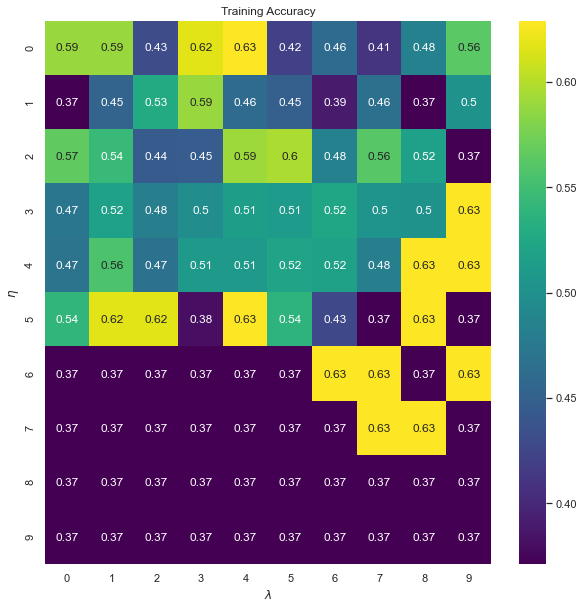

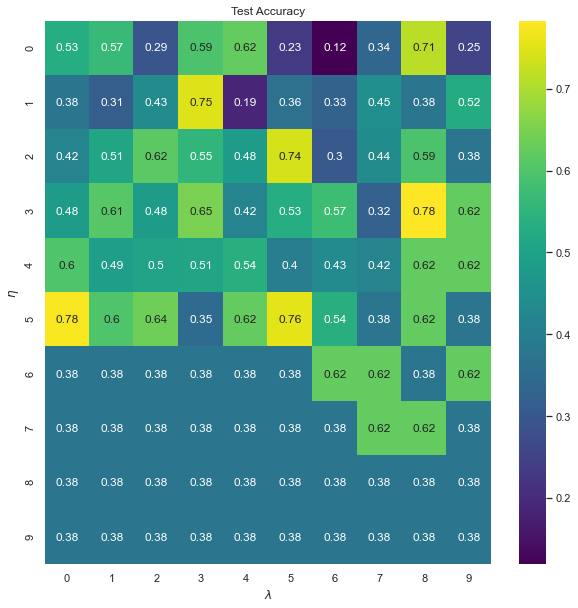

In [34]:
#===================================
#           Testing
#===================================

#-------------------   Data
#Data inputs
inputs = X_train

#Data ouputs
outputs = y_train

#Data inputs
inputs_test = X_test

#Data ouputs
outputs_test = y_test
#-------------------

N = inputs.shape[0]
# Hessian Matrix
H = (2.0/N)* X_train.T @ X_train
# Get the eigenvalues
EigValues, EigVectors = np.linalg.eig(H)
eta_max = 1.0/np.max(EigValues)

#-------------------  Dimension of our NN
batch_size = 5
nb_input_neurons = inputs.shape[0]         #Number of neurons inputs
nb_hidden_neurons = 32                     #Number of neurons by hidden layer
nb_output_neurons = 1                      #Number of neurons outputs
nb_features = inputs.shape[1]
nb_epochs = 500
nb_categories = 2

eta_vals = np.logspace(-7, 1, 10)
lmbd_vals = np.logspace(-7, 1, 10)
#-------------------

sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
compt = 0

for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
    
        prediction = NeuralNetwork(batch_size = 5, 
                                   nb_input_neurons = inputs.shape[0],
                                   nb_hidden_neurons = 32,
                                   nb_output_neurons = 2,
                                   nb_features = inputs.shape[1], 
                                   nb_categories = nb_categories,
                                   nb_epochs = 200,
                                   eta = eta,
                                   lmbd = lmbd, 
                                   inputs = inputs,
                                   outputs = outputs,
                                   inputs_test = inputs_test,
                                   activation = 'sigmoid')
        
        train_pred = prediction[1]
        test_pred = prediction[0]
        train_accuracy[i][j] = accuracy_score_numpy(outputs, train_pred)
        test_accuracy[i][j] = accuracy_score_numpy(outputs_test, test_pred)
        compt += 1
        
        print("step : " +str(compt) + "/" + str(len(eta_vals)*len(lmbd_vals)))

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

Epoch 1/200
86/86 [==============================] - 0s 771us/step - loss: 0.2486
Epoch 2/200
86/86 [==============================] - 0s 715us/step - loss: 0.2358
Epoch 3/200
86/86 [==============================] - 0s 727us/step - loss: 0.2343
Epoch 4/200
86/86 [==============================] - 0s 711us/step - loss: 0.2339
Epoch 5/200
86/86 [==============================] - 0s 729us/step - loss: 0.2344
Epoch 6/200
86/86 [==============================] - 0s 713us/step - loss: 0.2348
Epoch 7/200
86/86 [==============================] - 0s 726us/step - loss: 0.2367
Epoch 8/200
86/86 [==============================] - 0s 647us/step - loss: 0.2387
Epoch 9/200
86/86 [==============================] - 0s 668us/step - loss: 0.2345
Epoch 10/200
86/86 [==============================] - 0s 658us/step - loss: 0.2342
Epoch 11/200
86/86 [==============================] - 0s 670us/step - loss: 0.2351
Epoch 12/200
86/86 [==============================] - 0s 658us/step - loss: 0.2358
Epoch 13/200


86/86 [==============================] - 0s 636us/step - loss: 0.2204
Epoch 100/200
86/86 [==============================] - 0s 621us/step - loss: 0.2201
Epoch 101/200
86/86 [==============================] - 0s 630us/step - loss: 0.2185
Epoch 102/200
86/86 [==============================] - 0s 621us/step - loss: 0.2195
Epoch 103/200
86/86 [==============================] - 0s 643us/step - loss: 0.2133
Epoch 104/200
86/86 [==============================] - 0s 713us/step - loss: 0.2122
Epoch 105/200
86/86 [==============================] - 0s 690us/step - loss: 0.2176
Epoch 106/200
86/86 [==============================] - 0s 684us/step - loss: 0.2115
Epoch 107/200
86/86 [==============================] - 0s 653us/step - loss: 0.2097
Epoch 108/200
86/86 [==============================] - 0s 665us/step - loss: 0.2119
Epoch 109/200
86/86 [==============================] - 0s 655us/step - loss: 0.2009
Epoch 110/200
86/86 [==============================] - 0s 658us/step - loss: 0.2047
Epoch 

86/86 [==============================] - 0s 695us/step - loss: 0.1392
Epoch 197/200
86/86 [==============================] - 0s 702us/step - loss: 0.1325
Epoch 198/200
86/86 [==============================] - 0s 680us/step - loss: 0.1436
Epoch 199/200
86/86 [==============================] - 0s 669us/step - loss: 0.1557
Epoch 200/200
86/86 [==============================] - 0s 693us/step - loss: 0.1617


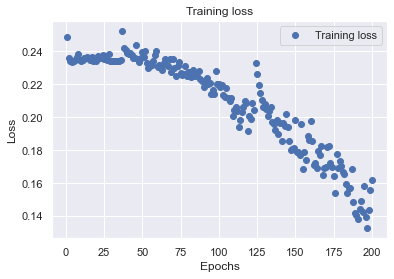

In [11]:
import tensorflow as tf
import numpy as np
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


n_hidden_neurons = 32
batch_size = 5
epochs = 200
activation_function = 'sigmoid'
optimizer = tf.keras.optimizers.Adam(learning_rate= eta_max)


model = Sequential()
model.add(Dense(n_hidden_neurons, activation = activation_function, input_dim = X_train.shape[1]))
model.add(Dense(units = n_hidden_neurons, activation = activation_function))
model.add(Dense(units = n_hidden_neurons, activation = activation_function))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = optimizer, loss = 'mean_squared_error')
model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs)


loss_values = model.history.history['loss']
epochs = range(1, epochs + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [12]:
prediction=model.predict(X_test)
prediction = (prediction>0.5)
print(accuracy_score_numpy(y_test,prediction))

80.92307692307692
